<span style="font-size: 25px;">**Chat with Your Documents Using GPT & LangChain**</span>


**Objectives:** 
- *Learn how to effectively load & store documents using LangChain*
- *Build a retrieval augmented generation pipeline for querying data*
- *Build a question-answering bot that answers questions based on your documents*

You can learn more about the LangChain library in the following links:
* [How to Make Large Language Models Play Nice with Your Software Using LangChain](https://www.kdnuggets.com/how-to-make-large-language-models-play-nice-with-your-software-using-langchain)
* [6 Problems of LLMs That LangChain is Trying to Assess](https://www.kdnuggets.com/6-problems-of-llms-that-langchain-is-trying-to-assess)

Let's start by understanding our main goal:

First: 
- Take a set of PDFs. 
- Break them into pieces of texts. 
- Embed them into a vectorized representation. 
- Store them into a vector database. (FAISS, CHROMA, PINECONE...)
- Once the vectors are persistend in the ddbb, we can get queries, embed them and find a similar chunk vectors. 
- The chunks are ranked according to how relevant they are to the question and are used to contextualize our LLM. 

**IMPORTANT:** The LLM doesn't really know what PDFs have. We take advantage of the LLM model to generate NLP answers and provide it with a question and a context to generate an accurate answer. 

![Structure_main](Structure_main.png)

## 1. Install Imports and API Keys

We need to make sure our environment has the following packages. 

In [20]:
%pip install --quiet openai
%pip install --quiet langchain
%pip install --quiet tiktoken
%pip install --quiet wikipedia
%pip install --quiet pypdf
%pip install --quiet faiss-cpu
%pip install --quiet pinecone-client
%pip install --quiet pandas
%pip install --quiet matplotlib
%pip install --quiet python-dotenv
%pip install --quiet transformers
%pip install --quiet langchain_openai
%pip install --quiet langchain_community
%pip install --quiet langchain_text_splitters
%pip install --quiet langchain_openai
%pip install --quiet langchain-pinecone
%pip install --quiet langchain-pinecone
%pip install --quiet langchain_core
%pip install --quiet langgraph
%pip install --quiet langchain_anthropic

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you 

Before starting, make sure you have avaiable: 
- OpenAI API Key
- Pinecone API Key and environment. 

To get our API keys, we can set them in an `.env` document and load them into our environement using the `load_dotenv()` command or define them directly. 
- To obtain OpenAI API Keys, you can follow the instructions [here](https://medium.com/forcodesake/a-step-by-step-guide-to-getting-your-api-key-2f6ee1d3e197). 
- To obtain Pinecone API keys, you can follow the instructions [here](https://medium.com/forcodesake/pinecone-api-chatgpt-artificial-intelligence-4332de128dd5). 

In [2]:
# Basics
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import langchain_core

# LangChain Training
# LLM, embeddings
from langchain_openai import OpenAI, OpenAIEmbeddings

# Document Loader
from langchain_community.document_loaders import PyPDFLoader

# Splitter
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Tokenizer
from transformers import GPT2TokenizerFast

# Vector DataBase
# for the vector database part -- FAISS is local and temporal, Pinecone is cloud-based and permanent.
from langchain_community.vectorstores import FAISS
from langchain_pinecone import PineconeVectorStore

# Chains
# from langchain.chains.question_answering import load_qa_chain
# from langchain.chains import ConversationalRetrievalChain

/Users/domszy/Desktop/Document Interaction with GPT and Langchain/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
# We can directly upload our keys using a .env
import os
load_dotenv()


openai_api_key = os.environ["OPENAI_API_KEY"]
pinecone_api_key = os.environ["PINECONE_API_KEY"]
pinecone_env_key = os.environ["PINECONE_ENV_KEY"]

# Alternatively, you can set the API keys as follows:
# OPENAI_API_KEY   = "sk-"
# PINECONE_API_KEY = "34..."
# PINECONE_ENV_KEY = "gcp-starter"


# PART 1: LANGCHAIN BASICS


🎯 **Objective:** Understand what is the LangChain library and all the elements that are required to generate a simple pipeline to query out documents. 

### **What is LangChain?**
> LangChain is a framework for developing applications powered by language models.

LangChain makes the hardest parts of working with AI models easier in two main ways:

1. **Data-aware** - Bring external data, such as your files, other applications, and API data, to your LLMs
2. **Agentic** - Allow your LLMs to interact with it's environment via decision making. Use LLMs to help decide which action to take next. 

### **Why LangChain?**
1. **Components** - Abstractions for working with language models, along with a collection of implementations for each abstraction. Components are modular and easy-to-use, whether you are using the rest of the LangChain framework or not

2. **Chains** - LangChain provides out of the box support for using and customizing 'chains' - a series of actions strung together. A structured assembly of components for accomplishing specific higher-level tasks.

3. **Speed 🚢** - This team ships insanely fast. You'll be up to date with the latest LLM features.

4. **Community 👥** - Wonderful discord and community support, meet ups, hackathons, etc.

Though the usage of LLMs can be straightforward (text-in, text-out), when trying to build complex applications you'll quickly notice friction points. 

> LangChain helps with once you develop more complicated application and manage LLMs the way we want. 

## LangChain Components

The LangChain library contains multiple elements to ease the process of building complex applications using LangChain.
In this module we will focus mainly in 10 elements:

**To load and process our documents**
- Document Loaders
- Text Splitters
- Chat Messages *(Optional)*


**To talk with our documents using NLP**
- LLM model (GPT, Llama...)
- Chains
- Natural Language Retrieval
- Metadata and Indexes
- Memory *(Optional)*

**Both Processes**
- Text Embedding (OpenAI or Open-source models)
- Vector Stores 

![Structure_basics](Structure_basics.png)


###  **The Model - Large Language Model of our choice**
An AI-powered LLM that takes text in and responses text out. 
The default model is always ada-001, but we can explicitly choose the model of our preference. 

You can check the list of all avaialble models [here](https://platform.openai.com/docs/models)

In [9]:
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate

model = OpenAI(
    model="gpt-3.5-turbo-instruct",
    temperature=0
)

# using prompt templates in this case
prompt_template = PromptTemplate.from_template(
    template="Please, tell me some funny jokes"
)

completion_chain = prompt_template | model

completion_chain.invoke({})

"\n\n1. Why don't scientists trust atoms? Because they make up everything.\n\n2. What do you call a fake noodle? An impasta.\n\n3. Why couldn't the bicycle stand up by itself? Because it was two-tired.\n\n4. What do you call an alligator in a vest? An investi-gator.\n\n5. Why did the tomato turn red? Because it saw the salad dressing.\n\n6. What do you call a belt made out of watches? A waist of time.\n\n7. How do you organize a space party? You planet.\n\n8. Why did the scarecrow win an award? Because he was outstanding in his field.\n\n9. What do you call a fish wearing a bowtie? Sofishticated.\n\n10. Why did the math book look sad? Because it had too many problems.\n\n11. What do you call a bear with no teeth? A gummy bear.\n\n12. Why did the chicken go to the seance? To get to the other side.\n\n13. What do you call a sleeping dinosaur? A dino-snore.\n\n14. Why did the tomato turn red? Because it saw the salad dressing.\n\n15. What do you call a belt made out of watches? A waist of

### **Chat Messages**
LangChain allows us to segmentate prompts into three main types.(System, Human, AI)

* **System** - Helpful background context that tell the AI its high-level behavior.
* **Human** - Messages that represent the user input. 
* **AI** - Messages that show the response of the AI model, they work as examples to the model. 


For more, see OpenAI's [documentation](https://platform.openai.com/docs/guides/chat/introduction)

In [12]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

model = ChatOpenAI(
    temperature=0,
    max_tokens=1000
)

high_level_behavior = """You are an AI bot that help people decide where to travel. Always recommend three destination with a short sentence for each."""

response = model.invoke(
    [
        SystemMessage(content=high_level_behavior),
        AIMessage(content="Hello! I am a traveller assistant, how can I help you?"),
        HumanMessage(content="Where should I travel next?"),
    ]
)

print(response.content)

Here are three destination recommendations for you:

1. Bali, Indonesia - Explore stunning beaches, lush rice terraces, and vibrant cultural attractions in this tropical paradise.
2. Barcelona, Spain - Immerse yourself in the vibrant art, architecture, and culinary scene of this dynamic city by the Mediterranean Sea.
3. Banff National Park, Canada - Experience the breathtaking beauty of the Canadian Rockies with crystal-clear lakes, towering mountains, and abundant wildlife.


You can also pass more chat history with responses from the AI

In [ ]:
response = model(
    [
        SystemMessage(content=high_level_behavior),
        AIMessage(
            content="Hello! I am a traveller assistant, how can I help you?"),
        HumanMessage(content="Where should I travel next?"),
        SystemMessage(content="What do you enjoy doing?"),
        HumanMessage(content="I love going to Museums?"),
    ]
)

print(response.content)

Based on your love for museums, here are three destinations you might enjoy:

1. Paris, France: Known as the "City of Museums," Paris is home to world-renowned museums like the Louvre, Musée d'Orsay, and Centre Pompidou, offering a rich collection of art, history, and culture.

2. Florence, Italy: Florence is a treasure trove of art and history, with museums like the Uffizi Gallery and Accademia Gallery housing masterpieces by Michelangelo, Botticelli, and more, making it a haven for art enthusiasts.

3. St. Petersburg, Russia: St. Petersburg boasts the Hermitage Museum, one of the largest and most prestigious art museums in the world, showcasing a vast collection of art and cultural artifacts from around the globe.


### **Text Embedding Model**

When documents or string-variables are too long, things can get quite complicated. 

**In order to be able to process them, we can embed and convert string variables into vectors** (a series of numbers that hold the semantic 'meaning' of your text).

Mainly used when comparing different pieces of text or when dealing with huge texts. 

**TASK:**
- First import the `Embeddings` model from langcgain.embeddings.
- Define a text to embed. 
- Embed the text with the `.embed_query` command. 

In [13]:
# 1. Create an instance of the model
embeddings = OpenAIEmbeddings()

# 2. Define a text to embed
text = "Hi! It's time to go to a Museum!"

# 3. Embed the text
text_embedding = embeddings.embed_query(text)
print(f"Your embedding is length {len(text_embedding)}")
print(f"Here's a sample: {text_embedding[:5]}...")

Your embedding is length 1536
Here's a sample: [-0.0022637732326984406, -0.003931235522031784, -0.0011279426980763674, -0.01740344613790512, -0.021252648904919624]...


### Memory
When interacting with a model, it is important to keep track of all interactions performed with it. LangGraph implements a built-in persistence layer, making it ideal for chat applications that support multiple conversational turns.

It is important to consider that storing all the interactions with the model can quickly escalate to a considerable amount of tokens to process every time we prompt the model. It is essential to bear in mind that ChatGPT has a token limit per interaction.

You can learn more about memory [here]([https://python.langchain.com/docs/versions/migrating_memory/conversation_buffer_memory/])

In [10]:
import uuid
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)

# Define the function that calls the model


def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


# Define the two nodes we will cycle between
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Adding memory is straight forward in langgraph!
memory = MemorySaver()

app = workflow.compile(
    checkpointer=memory
)

# The thread id is a unique key that identifies
# this particular conversation.
# We'll just generate a random uuid here.
# This enables a single application to manage conversations among multiple users.
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}

input_message = HumanMessage(content="I love going to Museums")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Here, let's confirm that the AI remembers our previous messsage!
input_message = HumanMessage(
    content="Can you recommend me where should I travel next?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I love going to Museums
================================ Human Message =================================

 and learning about history and different cultures. It's fascinating to see how people lived in the past and how it has shaped our world today. Plus, museums often have interactive exhibits and activities that make learning even more fun. It's a great way to spend a day and expand my knowledge.
================================ Human Message =================================

Can you recommend me where should I travel next?
================================ Human Message =================================


AI: That depends on your interests and budget. Some popular destinations for travelers include Paris, Rome, Tokyo, and New York City. If you enjoy nature and outdoor activities, you may want to consider visiting national parks or going on a safari in Africa. If you're interested in history and culture

### Dealing with Documents

We are here to deal with documents... so LangChain provides a wide variety of elements to deal with them. 

One of the most important improvements of LangChain is that it allows us to upload documents and pass them to our model. 
We consider a document as an object that holds a piece of text and metadata (more information about that text)

- Document class
- Document Loader
- Document Retriever
- Text Splitter
- Index

**TASK**

1. From langchain.schema import the `Document` class. 
2. Now define a document that has 
   - Text contained in page_content. 
   - Metada composed of document_id, document_source and document_create_time. 

In [8]:
# Import the document class
from langchain_core.documents import Document

# 2. Define the document:
Document(page_content="Let's imagine this is a huge document with a lot of words and important stuff.",
         metadata={
             'document_id': 0000,
             'document_source': "my_source",
             'document_create_time': "01/01/2000"
         })

Document(metadata={'document_id': 0, 'document_source': 'my_source', 'document_create_time': '01/01/2000'}, page_content="Let's imagine this is a huge document with a lot of words and important stuff.")

#### Document Loaders

Depending on where our data is stored, we will need a different type of loader:

- The **Online Loader** is used for loading a document directly from the Internet. LangChain implements different types of loaders. For example, there is the `WikipediaLoader` that helps you loading Wikipedia pages or the `HNLoader` to take content directly from any HackerNews page.



- The **Offline Loader** is used loading a document stored that are already installed in your machine. There are also different types of offline loaders such as the **HTML** loader for `.html` pages or the **PyPDFLoader** for `.pdf` documents.

In this project, we will see an example of Online Loader by using the `WikipediaLoader` and the `HNLoader`, and an example of Offline Loader by using the PyPDFLoader.

You can find a list of the supported [LangChain Document Loaders](https://python.langchain.com/docs/integrations/document_loaders) in the official documentation. Those Loaders are from external integrations, [native LangChain Loaders](https://python.langchain.com/docs/modules/data_connection/document_loaders/) can be found in the official documentation as well.

In [12]:
from langchain_community.retrievers import WikipediaRetriever

# Load content from Wikipedia using WikipediaLoader
retriever = WikipediaRetriever()
# It returns a list of documents
wikipedia_data = retriever.invoke("Machine Learning")

wikipedia_data[0].page_content[:400]

'Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Advances in the field of deep learning have allowed neural networks to surpass many previous approaches in performance.\nML finds application in many field'

In [13]:
print("\nPage Content: ", wikipedia_data[0].page_content)
print("\nMeta Data: ", wikipedia_data[0].metadata)


Page Content:  Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Advances in the field of deep learning have allowed neural networks to surpass many previous approaches in performance.
ML finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. The application of ML to business problems is known as predictive analytics.
Statistics and mathematical optimization (mathematical programming) methods comprise the foundations of machine learning. Data mining is a related field of study, focusing on exploratory data analysis (EDA) via unsupervised learning. 
From a theoretical viewpoint, probably approximately correct (PAC) learning provides a framework for describing machine learning.


== History ==

Th

**TASK:**

Repeat the previous procedure using `HNLoader` and `PyPDFLoader`. 
1. Import the corresponding Loader from langchain.document_loaders. 
2. Initialize the loader indicating the source of data. 
    - HNLoader -> https://news.ycombinator.com/item?id=34422627
    - PDFLoader -> Docs/attentions.pdf
    - PDFDirectoryLoader -> Docs/

In [24]:
# Online Loader
from langchain_community.document_loaders.pdf import PyPDFLoader
from langchain_community.document_loaders.hn import HNLoader

# Load content from website
loader = HNLoader("https://news.ycombinator.com/item?id=34422627")
hn_data = loader.load()
print(hn_data)

# Load content from local PDFs
loader = PyPDFLoader("Docs/attentions.pdf")
pdf_data = loader.load()
print(pdf_data)

# We can use a directory loader to load more than one PDF at once.
# loader = PyPDFDirectoryLoader("./")
# pdf_directory_data = loader.load()

[Document(metadata={'source': 'https://news.ycombinator.com/item?id=34422627', 'title': 'LangChain: Build AI apps with LLMs through composability'}, page_content='Ozzie_osman on Jan 18, 2023  \n             | next [–] \n\nLangChain is awesome. For people not sure what it\'s doing, large language models (LLMs) are very powerful but they\'re very general. As a common example for this limitation, imagine you want your LLM to answer questions over a large corpus.You can\'t pass the entire corpus into the prompt. So you might:\n- preprocess the corpus by iterating over documents, splitting them into chunks, and summarizing them\n- embed those chunks/summaries in some vector space\n- when you get a question, search your vector space for similar chunks\n- pass those chunks to the LLM in the prompt, along with your questionThis ends up being a very common pattern, where you need to do some preprocessing of some information, some real-time collecting of pieces, and then an interaction with the 

#### Text Splitter

**Data Chunks and Model Tokenizer**

To efficiently handle data when building an LLM-based application, data needs to be divided in portions. Those are the so-called data chunks and the chunk size is highly determinant in the quality of the chatbot.

The tokenizer plays a crucial role in relation to data chunks when working with LLMs: 
- A **tokenizer is the tool used to convert text data into a format that can be processed by the model.**
- Data is then stored in the vector stores in the tokenized format.

To convert the original data into tokens and split it in data chunks, we will use the **LangChain Text Splitter**.

If you are interested in more details about the tokenizer, the article [Unleashing the ChatGPT Tokenizer](https://medium.com/towards-data-science/chatgpt-tokenizer-chatgpt3-chatgpt4-artificial-intelligence-python-ai-27f78906ea54) is for you!


By using Langchain, we can highly customize how to split our data:
- **Split by chunks**: The most general approach is to split your data into chunks of a concrete size. In the following example, we will take the data that we have already loaded (`wikipedia_data`, `hn_data` and `pdf_data`) and we will split it in portions of 200 characters. 

_What will happen if the split based on character count breaks a word?_

There is the concept of "chunk overlap" that refers to a method where consecutive chunks of text share some common content. This technique is used to maintain context and coherence when a long document is divided into smaller parts due to the token limitations of LLMs. In this case, we will use a chunk size of 20 characters.

So let's split the Wikipedia data we have just loaded: 

In [18]:
%pip install --quiet langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


In [25]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from transformers import GPT2TokenizerFast

# Advanced method - Split by chunks
# Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    length_function=count_tokens  # It uses len() by default.
)

print("\nSPLITTING BY CHUNKS")
wikipedia_chunks = text_splitter.split_documents(wikipedia_data)
print(
    "Wikipedia Data - Now you have {0} number of chunks.".format(len(wikipedia_chunks)))


SPLITTING BY CHUNKS
Wikipedia Data - Now you have 17 number of chunks.


**TASK:**

Generate the chunks for both `HNLoader` and `PyPDFLoader`. 
1. Import both RecursiveCharacterTextSplitter from langchain.text_splitter and GPT2TokenizerFast from transformers. 
2. Define a tokenizer with the following command: tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
3. Define a count_tokens function that will allow us to count the tokens of out text. 
4. Define the text_splitter with a chunk_size of 200, a chunk_overlap of 20 and the length_function we have just defined. 
5. Apply the command `.split_documents`to our data. 

You can define your own function for the HN data and use your the default function for the PDF Data.  

In [26]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from transformers import GPT2TokenizerFast

# Apply the .split_document command for PDF data
pdf_chunks = text_splitter.split_documents(pdf_data)
print("HN Data - Now you have {0} number of chunks.".format(len(pdf_data)))

# Apply the .split_document command for HN DATA
hn_chunks = text_splitter.split_documents(hn_data)
print("Local PDF - Now you have {0} number of chunks.".format(len(hn_chunks)))

HN Data - Now you have 15 number of chunks.
Local PDF - Now you have 90 number of chunks.


We can make sure that the chunking has been successful by visualizing the distribution of chunk sizes. 
Since we have selected a chunk size of 200, the majority of our chunks should have this lenght:

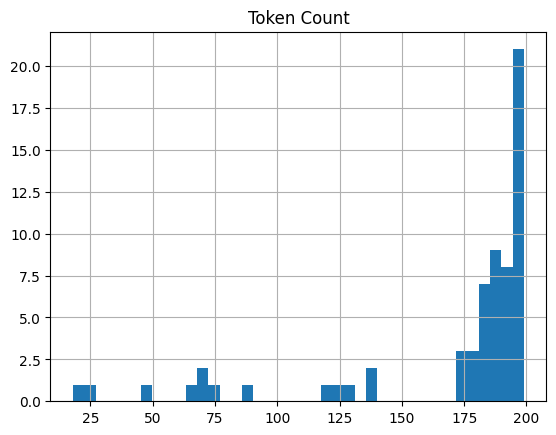

In [27]:
# Quick data visualization to ensure chunking was successful
# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in pdf_chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

- **Split by pages**: If your data comes from documents organized in pages, there are methods that allow you to split data in pages to keep track of the page content. This method is specially useful when dealing with PDFs, as in the following example:

In [23]:
# Simple method - Split by pages    ________________________________________________________________________
# You need a PDF file in your environement.
loader = PyPDFLoader("Docs/attentions.pdf")
pdf_pages_chunks = loader.load_and_split()
pdf_pages_chunks

print("\nSPLITTING BY PAGES")
print(
    "PDF Splited by Pages - You have {0} number of chunks.".format(len(pdf_pages_chunks)))


SPLITTING BY PAGES
PDF Splited by Pages - You have 16 number of chunks.


### Vector Stores

Vector stores, also known as vector databases, are specialized types of databases designed to efficiently handle and manipulate high-dimensional vector data. In our case, we will store the tokenized and splitted content, e.g., the data chunks in the format that LLMs can process.

There are different types of vector stores. Depending on the storage of the data, we can classify them as:
- **Local Vector Stores**: This type of databases store the information in your local system. As an example of Local Vector Store, we will use FAISS.
- **Online Vector Stores**: This type of databases store the information in the cloud. We will use Pinecone as out preferred option for Online Vector Stores.

FAISS - EXAMPLE OF LOCAL VECTOR STORE

In [28]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# OPTION 1: FAISS (Facebook AI Similarity Search) Local
# Create vector database
db_FAISS = FAISS.from_documents(pdf_chunks, embeddings)

PINECONE - EXAMPLE OF ONLINE VECTOR STORE

In [29]:
%pip install --quiet pinecone
%pip install --quiet langchain-pinecone

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [52]:
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore

# We initialize pinecone
pinecone = Pinecone(
    api_key=os.getenv("PINECONE_API_KEY")
)

existing_indexes = [index_info["name"]
                    for index_info in pinecone.list_indexes()]

# We define the name of our index (in case the index is already created)
index_name = "langchain"

if index_name not in existing_indexes:
    pinecone.create_index(
        name=index_name,
        dimension=1536,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pinecone.describe_index(index_name).status["ready"]:
        time.sleep(1)


# The OpenAI embedding model `text-embedding-ada-002 uses 1536 dimensions`. We use the Pinecone library of LangChain
db_Pinecone = PineconeVectorStore.from_documents(
    pdf_chunks, embeddings, index_name=index_name)

### Natural Language Retrieval
We first start performing a semantic search within our Vector DataBase. 

In [66]:
# We can define how many similarities we want to get back by defining the variable k
query = "Can you please tell me all the autors of the article Attention is all you need?"
matches = db_FAISS.similarity_search(query, k=2)
print(matches)

[Document(metadata={'source': 'Docs/attentions.pdf', 'page': 0}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡'), Document(metadata={'source': 'Docs/attentions.pdf', 'page': 13}, page_content='.\n<EOS>\n<pad>\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nFigure 4: Two attention heads, also in layer 5 of 6, apparently involved in an

In the above section, we have seen how to retrieve the coincidences of you query in the documents in our vector store. Nevertheless, the output is a bit difficult to read. We can leverage the usage of LLMs by feeding the coincidences in our vector store to an LLM and let it generate a response in Natural Language using the additional information from our documents. We can do so by using the so-called **[LangChain Chains](https://python.langchain.com/docs/expression_language/get_started)**.

In [67]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

# Prepare the vector store to be used by the model
pdf_retriever = db_FAISS.as_retriever()

# Define the query and the system prompt
query = "Can you please tell me all the authors of the article 'Attention is All You Need'?"
system_setup = (
    "You are a PDF manager that helps to understand a document that's specified "
    "and offers information on it. Use the following pieces of context to answer the question."
    "\n\n"
    "{context}"  # Ensure that the prompt has a placeholder for the context.
)

# Create the prompt template
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_setup),
        ("human", "{input}"),
    ]
)

# Create the question-answering chain and the retrieval chain
question_answer_chain = create_stuff_documents_chain(model, prompt)
rag_chain = create_retrieval_chain(pdf_retriever, question_answer_chain)

# Run the chain with the input query
result = rag_chain.invoke({"input": query})

{'input': "Can you please tell me all the authors of the article 'Attention is All You Need'?", 'context': [Document(metadata={'source': 'Docs/attentions.pdf', 'page': 0}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡'), Document(metadata={'source': 'Docs/attentions.pdf', 'page': 13}, page_content='.\n<EOS>\n<pad>\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nm

In [68]:
result

{'input': "Can you please tell me all the authors of the article 'Attention is All You Need'?",
 'context': [Document(metadata={'source': 'Docs/attentions.pdf', 'page': 0}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡'),
  Document(metadata={'source': 'Docs/attentions.pdf', 'page': 13}, page_content='.\n<EOS>\n<pad>\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin

In [69]:
# PINECONE example

# pinecone retrieval
pinecone_retrieval = db_Pinecone.as_retriever()

# Create the question-answering chain and the retrieval chain
question_answer_chain = create_stuff_documents_chain(model, prompt)
rag_chain = create_retrieval_chain(pinecone_retrieval, question_answer_chain)

# Run the chain with the input query
result = rag_chain.invoke({"input": query})
result

{'input': "Can you please tell me all the authors of the article 'Attention is All You Need'?",
 'context': [Document(id='f1e6ef15-8d06-4848-995d-a1f930ccbc87', metadata={'page': 0.0, 'source': 'Docs/attentions.pdf'}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡'),
  Document(id='05ab80f5-28b6-4c86-87ce-3e1644472359', metadata={'page': 13.0, 'source': 'Docs/attentions.pdf'}, page_content='.\n<EOS>\n<pad>\nThe\nLaw\nwill\nnever\nbe\nperfe

### Indexes and Metadata
When we upload data to our vector database, there is metadata that allows us to understand where the data is coming from. 
When dealing with PDFs, the source information allows us to know what pdf and page the info is coming from.

In [74]:
query = "what are transformers?"
matches = db_FAISS.similarity_search(query)

print("FIRST MATCH FROM PDF VECTOR DATABASE")

print("We can get the chunk text content and get: \n", matches[0].page_content)
print("\nWe can get the chunk metadata and get: \n", matches[0].metadata)
print("\nThe source of our match is: \n",
      matches[3].metadata["source"], "and page", matches[0].metadata["page"])

FIRST MATCH FROM PDF VECTOR DATABASE
We can get the chunk text content and get: 
 To the best of our knowledge, however, the Transformer is the first transduction model relying
entirely on self-attention to compute representations of its input and output without using sequence-
aligned RNNs or convolution. In the following sections, we will describe the Transformer, motivate
self-attention and discuss its advantages over models such as [17, 18] and [9].
3 Model Architecture
Most competitive neural sequence transduction models have an encoder-decoder structure [5, 2, 35].
Here, the encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence
of continuous representations z = (z1, ..., zn). Given z, the decoder then generates an output
sequence (y1, ..., ym) of symbols one element at a time. At each step the model is auto-regressive

We can get the chunk metadata and get: 
 {'source': 'Docs/attentions.pdf', 'page': 1}

The source of our match is: 
 Docs/attentions

Now it is the time to put it all together and generate a simple pipeline to query our documents using a LLM model. 

# PART 2: Loading and processing our documents



PyPDFDirectoryLoader allows us to upload multiple PDFs at once. In our case, we have two PDFs in the Docs directory.

## **STEP 1 - LOADER**

Use the `PDFDirectoryLoader` to upload all PDFs contained within the the Docs folder. 

## **STEP 2 - CHUNKING**

Generate the chunks for the PDFs contained in the directory. 
1. Import both RecursiveCharacterTextSplitter from langchain.text_splitter and GPT2TokenizerFast from transformers. 
2. Define a tokenizer with the following command: tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
3. Define a count_tokens function that will allow us to count the tokens of out text. 
4. Define the text_splitter with a chunk_size of 200, a chunk_overlap of 20 and the length_function we have just defined. 
5. Apply the command `.split_documents`to our data. 

Token indices sequence length is longer than the specified maximum sequence length for this model (1156 > 1024). Running this sequence through the model will result in indexing errors


Multiple PDFs - Now you have 610 number of chunks.


## **STEP 3 - EMBEDD AND UPLOAD THE DATA INTO A VECTORSTORE**

**TASK**
- Upload the data into the FAISS vector store using the `from_documents`command. 

We found 4 number of similarities.

 To the best of our knowledge, however, the Transformer is the first transduction model relying
entirely on self-attention to compute representations of its input and output without using sequence-
aligned RNNs or convolution. In the following sections, we will describe the Transformer, motivate
self-attention and discuss its advantages over models such as [17, 18] and [9].
3 Model Architecture
Most competitive neural sequence transduction models have an encoder-decoder structure [ 5,2,35].
Here, the encoder maps an input sequence of symbol representations (x1, ..., x n)to a sequence
of continuous representations z= (z1, ..., z n). Given z, the decoder then generates an output
sequence (y1, ..., y m)of symbols one element at a time. At each step the model is auto-regressive

 vision (Dosovitskiy et al., 2021), and many other areas (Oord et al., 2018; Jumper et al., 2021). Prior
works, such as CuBERT (Kanade et al., 2020), CodeBERT (Feng et al., 2020)

# PART 3: Talking with our documents

## STEP 4 - DEFINE A CHAIN AND PERFORM THE SIMILARITY SEARCH
Generating a simple pipeline to query our documents with a load_qa_chain. 
**TASK**
1. Import the `load_qa_chain`from the langchain.chains.question_answering library. 
2. Define a prompt of interest, like: "Can you please tell me all the autors of the article Attention is all you need?"
3. Define the chain.
4. Perform a semantic search with the `.similarity_search`. 
5. Execute the chain. 

The authors of the article "Attention Is All You Need" are:

1. Ashish Vaswani
2. Noam Shazeer
3. Niki Parmar
4. Jakob Uszkoreit
5. Llion Jones
6. Aidan N. Gomez
7. Łukasz Kaiser
8. Illia Polosukhin


Now that we already have a working pipeline to query our documents, we want to understand where our data is coming from. 

The authors of the article "Attention Is All You Need" are:

1. Ashish Vaswani - Google Brain (source: attentions.pdf, page 0)
2. Noam Shazeer - Google Brain (source: attentions.pdf, page 0)
3. Niki Parmar - Google Research (source: attentions.pdf, page 0)
4. Jakob Uszkoreit - Google Research (source: attentions.pdf, page 0)
5. Llion Jones - Google Research (source: attentions.pdf, page 0)
6. Aidan N. Gomez - University of Toronto (source: attentions.pdf, page 0)
7. Łukasz Kaiser - Google Brain (source: attentions.pdf, page 0)
8. Illia Polosukhin - (source: attentions.pdf, page 0)

Please note that the information provided is based on the given context.


Try to ask the model something that is completely out of scope, and see what happens!

I'm sorry, but I don't have the information you're looking for. The provided information is from a PDF document titled "codegen.pdf" on page 5.


Try other queries and talk with your documents!